## <center>Курсовой проект<a class="anchor" id="theory"></a><center>

**Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
import xgboost as xgb
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

**Пути к файлам и фукнции для дальнейшей работы**

In [86]:
DATA_ROOT = Path('./data/')
MODELS_PATH = Path('./models/')

# input
DATASET_PATH = DATA_ROOT / 'course_project_train.csv'
DATASET_PATH_TEST = DATA_ROOT / 'course_project_test.csv'
# output
SUBMISSION_SAMPLE = DATA_ROOT / 'sample_submission.csv'
SUBMISSION= DATA_ROOT / 'MVKharitonov_predictions.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

In [3]:
def eval_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('Train: \n' + classification_report(y_train_true, y_train_pred))
    print('Test: \n' + classification_report(y_test_true, y_test_pred))

In [4]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    eval_metrics(y_train, y_train_pred, y_test, y_test_pred)

**Загрузка данных и описание переменных**

In [5]:
df = pd.read_csv(DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [7]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

Просмотрим переменные и вычислим категориальные и количественные признаки

In [8]:
for i in df.columns:
    print(i + ':')
    print(df[i].value_counts().sort_values(ascending = False))
    print()
    

Home Ownership:
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Annual Income:
1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1539152.0    1
1177411.0    1
266000.0     1
785954.0     1
2083825.0    1
Name: Annual Income, Length: 5478, dtype: int64

Years in current job:
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Tax Liens:
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

Number of Open Accounts:
9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20

Выделем имя целевой переменной, основные признаки, категориальные, количественные и категориальные, но при этом числовые

In [9]:
TARGET = 'Credit Default'
BASE_FEATURES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']
CAT_FEATURES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
NUM_FEATURES = ['Annual Income', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']
CAT_FEATURES_PL = ['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']

Найдем пустые значения

In [10]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Вычислим средние

In [11]:
Ann_Inc_med = df['Annual Income'].median()
Years_in_curr_jb_mode = df['Years in current job'].mode()[0]
Mnth_lst_delinq = df['Months since last delinquent'].median()
Bnkrupt_mode = df['Bankruptcies'].mode()[0]
Cr_sc_med = df['Credit Score'].median()

**Построим базовую модель**

Разобьем параметры на целевую переменную и выборку(выборку возьмем без категориальных переменных)

In [12]:
y = df[TARGET]
X = df.drop(columns = [TARGET] + CAT_FEATURES)

Разобьем выборку на тест и трейн и заполним пропуски

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)


X_train['Annual Income'] = X_train['Annual Income'].fillna(Ann_Inc_med)
#X_train['Years in current job'] = X_train['Years in current job'].fillna(Years_in_curr_jb_mode)
X_train['Months since last delinquent'] = X_train['Months since last delinquent'].fillna(Mnth_lst_delinq)
X_train['Bankruptcies'] = X_train['Bankruptcies'].fillna(Bnkrupt_mode)
X_train['Credit Score'] = X_train['Credit Score'].fillna(Cr_sc_med)
X_val['Annual Income'] = X_val['Annual Income'].fillna(Ann_Inc_med)
#X_val['Years in current job'] = X_val['Years in current job'].fillna(Years_in_curr_jb_mode)
X_val['Months since last delinquent'] = X_val['Months since last delinquent'].fillna(Mnth_lst_delinq)
X_val['Bankruptcies'] = X_val['Bankruptcies'].fillna(Bnkrupt_mode)
X_val['Credit Score'] = X_val['Credit Score'].fillna(Cr_sc_med)

Для базовой модели возьмем случайный лес, обучим его и посчитаем метрики на тесте и валидационной выборке

In [14]:
rfc = RandomForestClassifier(criterion='gini',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42, 
                                 n_estimators=100  # кол-во деревьев
                                 )

rfc.fit(X_train, y_train)
y_train_preds = rfc.predict(X_train)
y_val_preds = rfc.predict(X_val)

eval_metrics(y_train, y_train_preds, y_val, y_val_preds)

Train: 
              precision    recall  f1-score   support

           0       0.76      1.00      0.87      3771
           1       1.00      0.21      0.35      1479

    accuracy                           0.78      5250
   macro avg       0.88      0.61      0.61      5250
weighted avg       0.83      0.78      0.72      5250

Test: 
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1616
           1       0.99      0.19      0.32       634

    accuracy                           0.77      2250
   macro avg       0.87      0.59      0.59      2250
weighted avg       0.82      0.77      0.71      2250



**EDA**

Функция для вычисления доверительного интервала

In [15]:
def conf_intervals(data, feat, TARGET):
    feature_with_target = data[[feat, TARGET]]
    feature = feature_with_target[feat]
    feature_with_target_0 = feature[feature_with_target[TARGET] == 0]
    feature_with_target_1 = feature[feature_with_target[TARGET] == 1]

    plt.figure(figsize=(4, 3))

    sns.pointplot(x=TARGET, y=feat, data=feature_with_target, capsize=.1)

    plt.title('Confidence intervals (95 %) for ' + feat)
    plt.show()

Загрузим данные заново, для лучшей обработки

In [16]:
df = pd.read_csv(DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [17]:
TARGET = 'Credit Default'
BASE_FEATURES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']
CAT_FEATURES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
NUM_FEATURES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount', 
       'Current Credit Balance', 'Monthly Debt', 'Credit Score']
CAT_FEATURES_PL = ['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']

Рассмотрим целевую переменную и баланс классов. Видно, что классы разбалансированы

In [18]:
df[TARGET].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Рассмотрим корреляцию переменных с целевой переменной

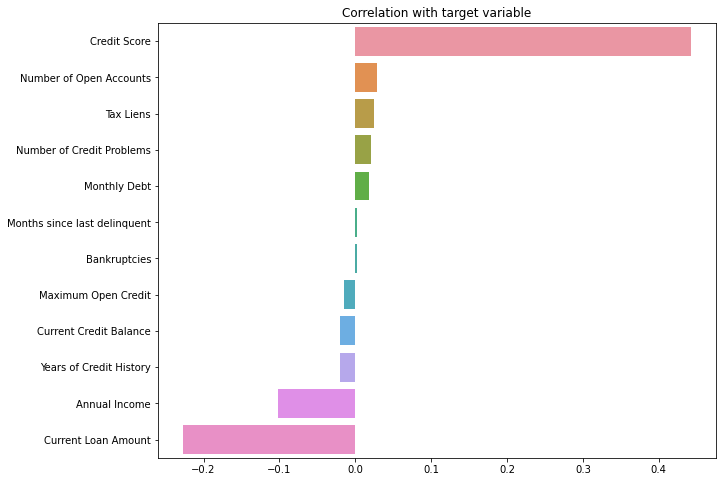

In [19]:
corr_with_target = df[BASE_FEATURES + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Рассмотрим доверительные интервалы для количественных переменных.
для всех переменных строим одинаковые гипотезы.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезы сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

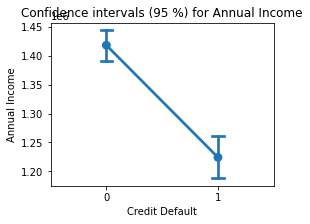

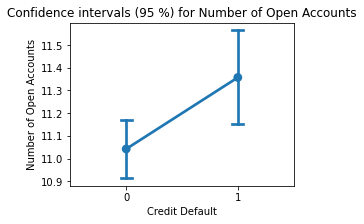

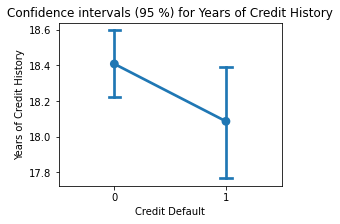

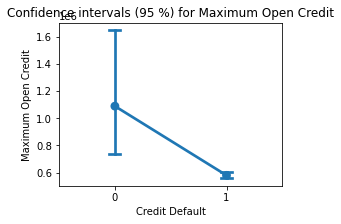

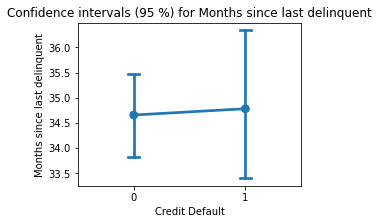

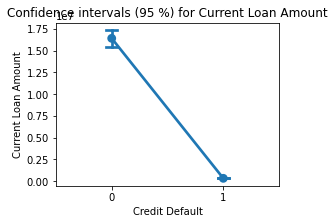

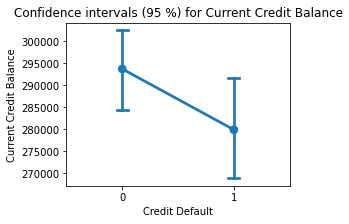

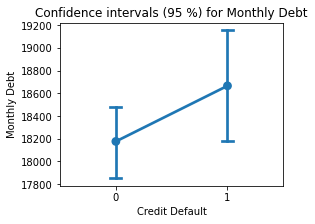

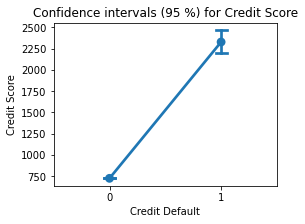

In [20]:
for i in NUM_FEATURES:
    conf_intervals(df, i, TARGET)

Видно, что для перменной 'Month since last delinquent' , группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак не будет полезен для определения значения целевой переменной. Есть еще несколько проблемных перменных, но мы не будем от них избавляться


In [21]:
H1_NUM_FEATURE = ['Month since last delinquent']
H1_NUM_FEATURE

['Month since last delinquent']

Функция для построения графиков категориальных перменных

In [22]:
def class_analysis(data, feat, TARGET):
    print(data[feat].value_counts())
    plt.figure(figsize=(10, 8))

    sns.countplot(x=feat, hue=TARGET, data=data)
    plt.title(feat + ' grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()

Построим графики распределения для категориальных переменных и рассмотрим хи2- распределение. Для всех параметров будет рассматривать следующую гипотезу:

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64


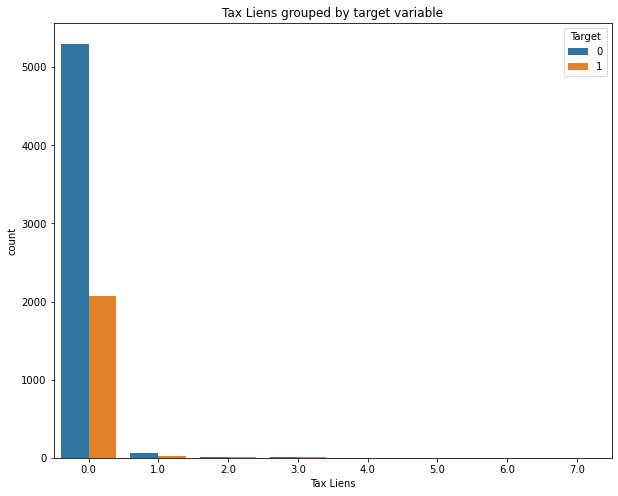

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64


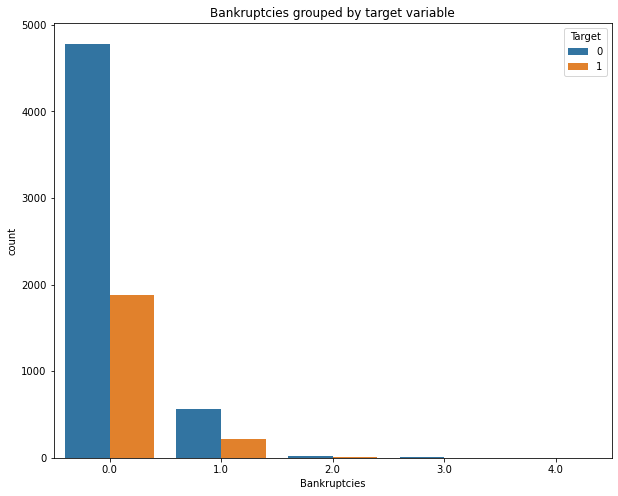

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64


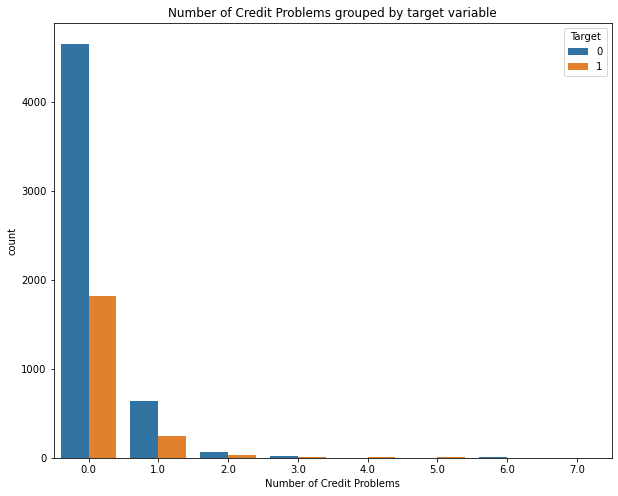

In [23]:
for i in CAT_FEATURES_PL:
    class_analysis(df, i, TARGET)
    

In [24]:
def chi2_analys(data, feat, TARGET, lst):
    data['Id'] = data.index
    feat_and_target_s = data.loc[data[feat].isin(lst), ['Id', feat, TARGET]]
    print(lst)
    table = feat_and_target_s.pivot_table(values='Id', index=feat, columns=TARGET, aggfunc='count')
    chi2, p, _, _ = chi2_contingency(table)
    display(table, p) 

In [25]:
chi2_analys(df, 'Tax Liens', TARGET, [0,1])
chi2_analys(df, 'Tax Liens', TARGET, [0,2])
chi2_analys(df, 'Tax Liens', TARGET, [2,3])
chi2_analys(df, 'Tax Liens', TARGET, [2,4])
chi2_analys(df, 'Tax Liens', TARGET, [2,5])
chi2_analys(df, 'Tax Liens', TARGET, [6,7])

[0, 1]


Credit Default,0,1
Tax Liens,,
0.0,5301,2065
1.0,59,24


0.956212700856196

[0, 2]


Credit Default,0,1
Tax Liens,,
0.0,5301,2065
2.0,15,15


0.0136220882228766

[2, 3]


Credit Default,0,1
Tax Liens,,
2.0,15,15
3.0,5,5


1.0

[2, 4]


Credit Default,0,1
Tax Liens,,
2.0,15,15
4.0,3,3


1.0

[2, 5]


Credit Default,0,1
Tax Liens,,
2.0,15,15
5.0,1,1


1.0

[6, 7]


Credit Default,0
Tax Liens,
6.0,2
7.0,1


1.0

Так как у нас двусторонняя критическая область, то все параметры имеют различное распределение

In [26]:
chi2_analys(df, 'Bankruptcies', TARGET, [0,1])
chi2_analys(df, 'Bankruptcies', TARGET, [0,2])
chi2_analys(df, 'Bankruptcies', TARGET, [0,3])
chi2_analys(df, 'Bankruptcies', TARGET, [0,4])

[0, 1]


Credit Default,0,1
Bankruptcies,,
0.0,4782,1878
1.0,569,217


0.7596089792886996

[0, 2]


Credit Default,0,1
Bankruptcies,,
0.0,4782,1878
2.0,20,11


0.48447231725447537

[0, 3]


Credit Default,0,1
Bankruptcies,,
0.0,4782,1878
3.0,5,2


0.6904249396970157

[0, 4]


Credit Default,0,1
Bankruptcies,,
0.0,4782,1878
4.0,1,1


0.9197637533480871

Распредление во всех классах похоже, значит можно считать, что классы не несут влияния на  целевую переменную

In [27]:
H1_NUM_FEATURE = H1_NUM_FEATURE + ['Bankruptcies']
H1_NUM_FEATURE

['Month since last delinquent', 'Bankruptcies']

In [28]:
chi2_analys(df, 'Number of Credit Problems', TARGET, [0,1])
chi2_analys(df, 'Number of Credit Problems', TARGET, [0,2])
chi2_analys(df, 'Number of Credit Problems', TARGET, [0,3])
chi2_analys(df, 'Number of Credit Problems', TARGET, [4,5])
chi2_analys(df, 'Number of Credit Problems', TARGET, [6,7])

[0, 1]


Credit Default,0,1
Number of Credit Problems,,
0.0,4654,1815
1.0,641,241


0.6783214582441461

[0, 2]


Credit Default,0,1
Number of Credit Problems,,
0.0,4654,1815
2.0,60,33


0.14293426550821686

[0, 3]


Credit Default,0,1
Number of Credit Problems,,
0.0,4654,1815
3.0,21,14


0.16794181852981627

[4, 5]


Credit Default,0,1
Number of Credit Problems,,
4.0,3,6
5.0,3,4


0.8964714792354563

[6, 7]


Credit Default,0
Number of Credit Problems,
6.0,4
7.0,1


1.0

Классы 6 и 7 считаем выбросами. Все остальные классы можно объединить в один, так как p-value больше критичсекого уровня значимости

In [29]:
H1_NUM_FEATURE = H1_NUM_FEATURE + ['Number of Credit Problems']

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64


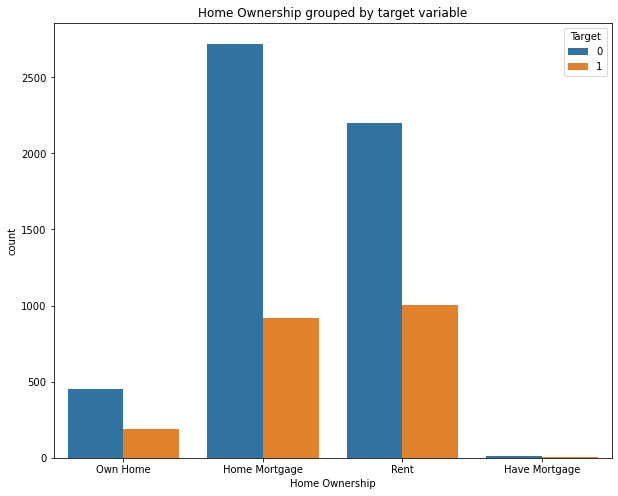

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64


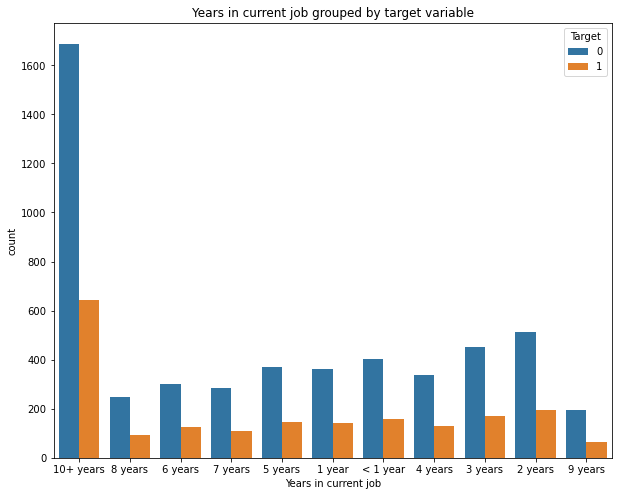

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64


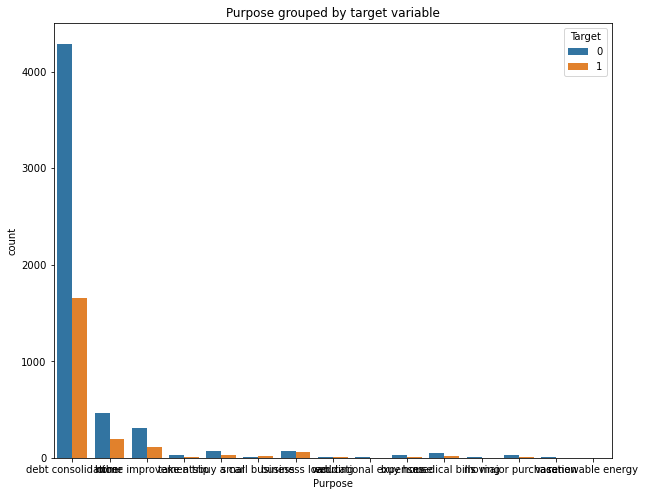

Short Term    5556
Long Term     1944
Name: Term, dtype: int64


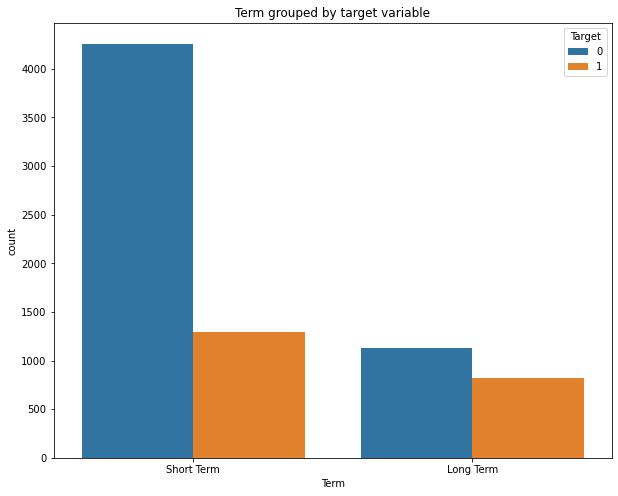

In [30]:
for i in CAT_FEATURES:
    class_analysis(df, i, TARGET)

In [31]:
chi2_analys(df, 'Home Ownership', TARGET, ['Have Mortgage', 'Home Mortgage'])
chi2_analys(df, 'Home Ownership', TARGET, ['Rent','Home Mortgage'])
chi2_analys(df, 'Home Ownership', TARGET, ['Rent', 'Own Home'])
chi2_analys(df, 'Home Ownership', TARGET, ['Home Mortgage', 'Own Home'])

['Have Mortgage', 'Home Mortgage']


Credit Default,0,1
Home Ownership,,
Have Mortgage,10,2
Home Mortgage,2721,916


0.7295033251987646

['Rent', 'Home Mortgage']


Credit Default,0,1
Home Ownership,,
Home Mortgage,2721,916
Rent,2201,1003


2.2122322110125114e-08

['Rent', 'Own Home']


Credit Default,0,1
Home Ownership,,
Own Home,455,192
Rent,2201,1003


0.44101063428849807

['Home Mortgage', 'Own Home']


Credit Default,0,1
Home Ownership,,
Home Mortgage,2721,916
Own Home,455,192


0.018554563643657606

Даже невооруженным взглядом видно, что классы 'Have Mortgage' и 'Home Mortgage' скорее всего просто опечатка и могут быть объединены в один. Но даже, исходя из нашей гипотезы, можно заметить, что гипотеза H0 не отвергается. Так же можно объединить классы 'Rent' и 'Own Home', так как рапределения в них близки

Рассмотрим гистограммы для всех количсетвенных признаков.

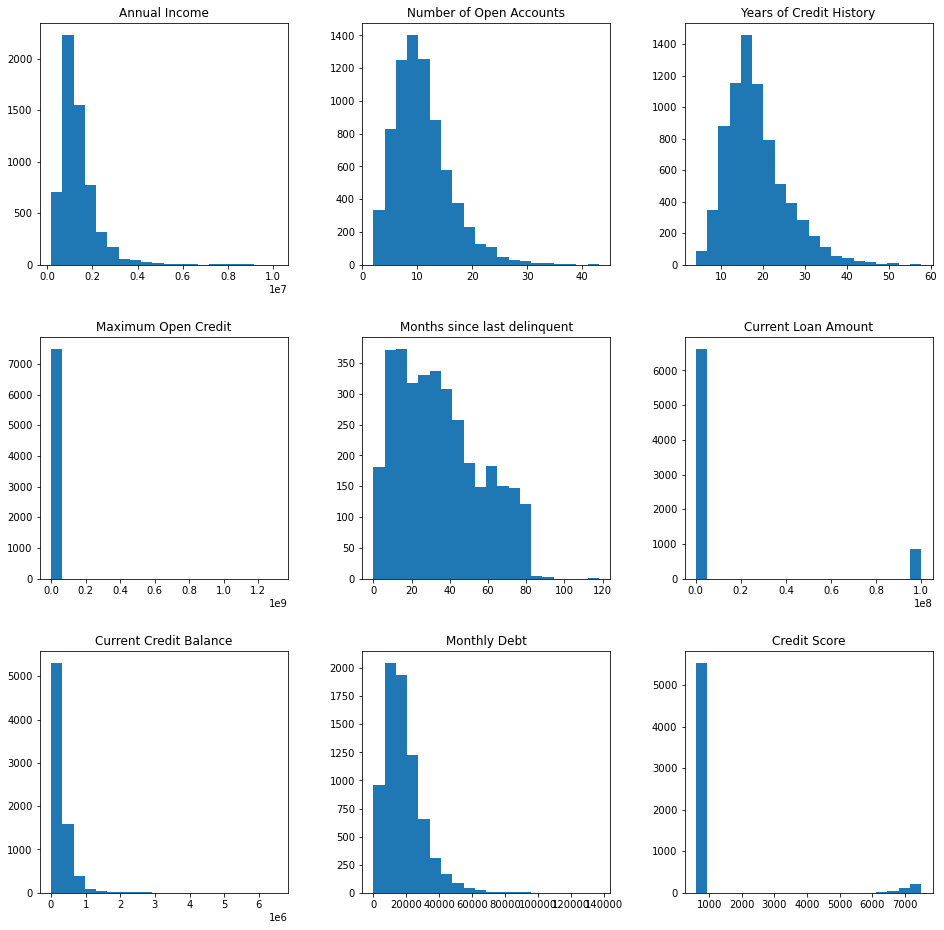

In [32]:
df[NUM_FEATURES].hist(figsize=(16, 16), bins=20, grid=False);

Из данных гистограм можно понять, что есть выбросы. Можно выбрать какое-нибудь значение например для 'Number of Open Accounts' - 40. Но мы будем использовать персентиль 0.95

In [33]:
df_nf = df[NUM_FEATURES]

In [34]:
for i in NUM_FEATURES:
    new_name = i + '_cl'
    df_nf[new_name] = 0
    df_nf.loc[df_nf[i] > df_nf[i].quantile(0.95), new_name] = 1
    print(df_nf[new_name].value_counts())

0    7202
1     298
Name: Annual Income_cl, dtype: int64
0    7144
1     356
Name: Number of Open Accounts_cl, dtype: int64
0    7130
1     370
Name: Years of Credit History_cl, dtype: int64
0    7125
1     375
Name: Maximum Open Credit_cl, dtype: int64
0    7348
1     152
Name: Months since last delinquent_cl, dtype: int64
0    7500
Name: Current Loan Amount_cl, dtype: int64
0    7125
1     375
Name: Current Credit Balance_cl, dtype: int64
0    7125
1     375
Name: Monthly Debt_cl, dtype: int64
0    7205
1     295
Name: Credit Score_cl, dtype: int64


Рассмотрим матрицу корреляции признаков между собой.

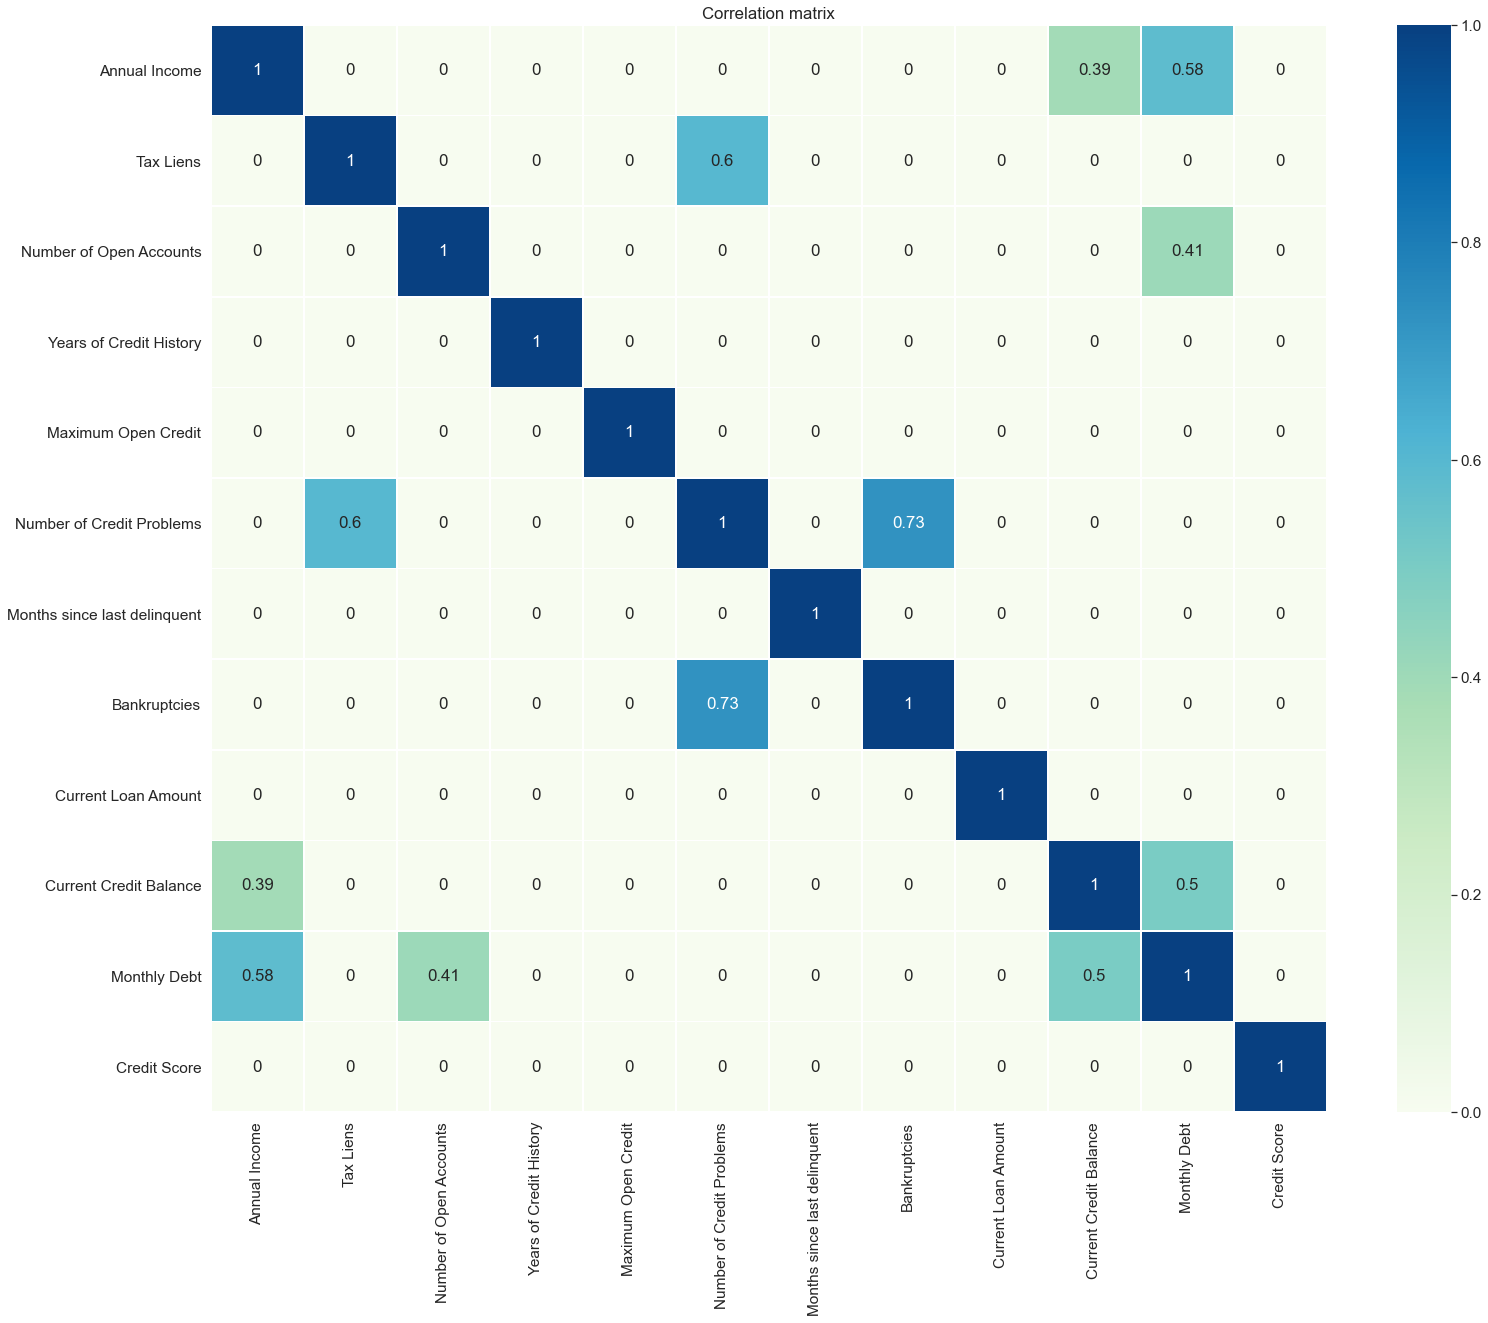

In [35]:
corr_matrix = df[BASE_FEATURES].corr()
corr_matrix = np.round(corr_matrix, 2)

plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[BASE_FEATURES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Number of Credit problems достаточно хорошо коррелируют с Tax Lies  и с Bankrupties, от этого параметра можно было бы избавиться, особенно, учитывая, что этот параметр не очень сильно коррелирует с целевой переменной. Но мы не будем использовать линейную модель, а значит можно данный параметр оставить.

**Предобработка данных**

Выбросы мы оперделили в предыдущем пункте. Всем выбросам поставим в соответствие значени nan. После чего заполним пропуски и выбросы с помощью построенной модели. Так же создадим новые параметры, которые будут идентифицировать объекты, у которых был заполнен пропуск.

In [36]:
def na_fill(data, feat, threshold):
    data.loc[(data[feat] > threshold), feat] = np.nan
    return df

*Категориальные переменные*

Заменим 'Have Mortgage' на 'Home Mortgage', а так же объединим классы 'Own Home' и 'Rent'. Для всех классов сделаем дамми переменные.

In [37]:
df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
df.loc[df['Home Ownership'] == 'Own Home', 'Home Ownership'] = 'Rent'
df = pd.concat([df, pd.get_dummies(df['Home Ownership'])], axis=1)
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Id', 'Home Mortgage', 'Rent'],
      dtype='object')

Сделаем дамми переменные для признака 'Purpose' и все новые переменные запишем в список

In [38]:
df = pd.concat([df, pd.get_dummies(df['Purpose'])], axis=1)
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Id', 'Home Mortgage', 'Rent',
       'business loan', 'buy a car', 'buy house', 'debt consolidation',
       'educational expenses', 'home improvements', 'major purchase',
       'medical bills', 'moving', 'other', 'renewable energy',
       'small business', 'take a trip', 'vacation', 'wedding'],
      dtype='object')

In [39]:
NEW_FEATURES = ['Home Mortgage', 'Rent',
       'business loan', 'buy a car', 'buy house', 'debt consolidation',
       'educational expenses', 'home improvements', 'major purchase',
       'medical bills', 'moving', 'other', 'renewable energy',
       'small business', 'take a trip', 'vacation', 'wedding'] 

Заполним пропуски средними значениями и добавим новые переменные в список

In [40]:
Ann_Inc_med = df['Annual Income'].median()
Years_in_curr_jb_mode = df['Years in current job'].mode()[0]
Mnth_lst_delinq = df['Months since last delinquent'].median()
Bnkrupt_mode = df['Bankruptcies'].mode()[0]
Cr_sc_med = df['Credit Score'].median()

df['Annual Income'] = df['Annual Income'].fillna(Ann_Inc_med)
df['Years in current job'] = df['Years in current job'].fillna(Years_in_curr_jb_mode)
df['Months since last delinquent'] = df['Months since last delinquent'].fillna(Mnth_lst_delinq)
df['Bankruptcies'] = df['Bankruptcies'].fillna(Bnkrupt_mode)
df['Credit Score'] = df['Credit Score'].fillna(Cr_sc_med)

df['Years in current job'] = df['Years in current job'].fillna(Years_in_curr_jb_mode)
df['Years in job num'] = df['Years in current job'].map({'< 1 year':'0', 
                                                     '1 year':'1',
                                                     '2 years':'2',
                                                     '3 years':'3',
                                                     '4 years':'4',
                                                     '5 years':'5',
                                                     '6 years':'6',
                                                     '7 years':'7',
                                                     '8 years':'8',
                                                     '9 years':'9',
                                                     '10+ years':'10'
                                                    }).astype(int)

df['Term_num'] = df['Term'].map({'Short Term':'0', 
                                  'Long Term':'1'}).astype(int)

NEW_FEATURES = NEW_FEATURES + ['Term_num']

Обработаем выбросы в 'Tax Liens', как было описано выше и заполним их медианами

In [41]:
na_fill(df, 'Tax Liens', 3)
df['Tax Liens'] = df['Tax Liens'].fillna(df['Tax Liens'].median())

In [42]:
H1_NUM_FEATURE

['Month since last delinquent', 'Bankruptcies', 'Number of Credit Problems']

In [43]:
df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
Id                              0
Home Mortgage                   0
Rent                            0
business loan                   0
buy a car                       0
buy house                       0
debt consolidation              0
educational expenses            0
home improvements               0
major purchase                  0
medical bills                   0
moving                          0
other         

Количественные признаки

Заполни выбросы средними значениями

In [44]:
for i in NUM_FEATURES:
    na_fill(df, i, df[i].quantile(0.995))
    df[i] = df[i].fillna(df[i].median())

In [45]:
df.isna().sum().sum()

0

In [46]:
medians_num = dict()
for i in NUM_FEATURES:
    medians_num.update({i: X[i].median()})
    print(df[i].median())
medians_num['Annual Income']    

1168386.0
10.0
17.0
476223.0
32.0
309573.0
208430.0
15995.0
731.0


1168386.0

Создадим класс для обработки данных

In [71]:
class DataPreprocessing:
     
    def __init__(self):
        self.medians_num = dict()
        self.Ann_Inc_med = None
        self.Years_in_curr_jb_mode = None
        self.Mnth_lst_delinq = None
        self.Bnkrupt_mode = None
        self.Cr_sc_med = None
        self.dict_Years_jb = None
        self.dict_Term = None
        self.Tax_med = None
        self.quantile_num = dict()
        self.NUM_FEATURES =None
        
    def fit(self, X, NUM_FEATURES):
        X = X.copy()
        self.NUM_FEATURES = NUM_FEATURES
        self.Ann_Inc_med = df['Annual Income'].median()
        self.Years_in_curr_jb_mode = df['Years in current job'].mode()[0]
        self.Mnth_lst_delinq = df['Months since last delinquent'].median()
        self.Bnkrupt_mode = df['Bankruptcies'].mode()[0]
        self.Cr_sc_med = df['Credit Score'].median()
        self.dict_Years_jb = {'< 1 year':'0', 
                         '1 year' : '1',
                         '2 years':'2',
                         '3 years':'3',
                         '4 years':'4',
                         '5 years':'5',
                         '6 years':'6',
                         '7 years':'7',
                         '8 years':'8',
                         '9 years':'9',
                         '10+ years':'10'}
        self.dict_Term = {'Short Term':'0', 
                      'Long Term':'1'}
        for i in self.NUM_FEATURES:
            self.medians_num.update({i: X[i].median()})
            self.quantile_num.update({i: X[i].quantile(0.995)})
        self.Tax_med = X['Tax Liens'].median()
        
        
    def transform(self, X):
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        X.loc[X['Home Ownership'] == 'Own Home', 'Home Ownership'] = 'Rent'
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        X = pd.concat([X, pd.get_dummies(X['Purpose'])], axis=1)
        X['Annual Income'] = X['Annual Income'].fillna(self.Ann_Inc_med)
        X['Years in current job'] = X['Years in current job'].fillna(self.Years_in_curr_jb_mode)
        X['Months since last delinquent'] = X['Months since last delinquent'].fillna(self.Mnth_lst_delinq)
        X['Bankruptcies'] = X['Bankruptcies'].fillna(self.Bnkrupt_mode)
        X['Credit Score'] = X['Credit Score'].fillna(self.Cr_sc_med)

        X['Years in current job'] = X['Years in current job'].fillna(self.Years_in_curr_jb_mode)
        X['Years in job num'] = X['Years in current job'].map(self.dict_Years_jb).astype(int)

        X['Term_num'] = X['Term'].map(self.dict_Term).astype(int)
        
        na_fill(X, 'Tax Liens', 3)
        X['Tax Liens'] = X['Tax Liens'].fillna(self.Tax_med)
#        X[self.NUM_FEATURES] = X[self.NUM_FEATURES].astype(float)
#        display(self.medians_num)
 #       for i in self.NUM_FEATURES:
 #           X[i] = na_fill(X, i, self.quantile_num[i])
#            display(self.medians_num[i])
#            X[i] = X[i].fillna(self.medians_num[i])
#        X[self.NUM_FEATURES] = X[self.NUM_FEATURES].astype(float)
        return X
     def transform(self, X):
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        X.loc[X['Home Ownership'] == 'Own Home', 'Home Ownership'] = 'Rent'
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        X = pd.concat([X, pd.get_dummies(X['Purpose'])], axis=1)
        X['Annual Income'] = X['Annual Income'].fillna(self.Ann_Inc_med)
        X['Years in current job'] = X['Years in current job'].fillna(self.Years_in_curr_jb_mode)
        X['Months since last delinquent'] = X['Months since last delinquent'].fillna(self.Mnth_lst_delinq)
        X['Bankruptcies'] = X['Bankruptcies'].fillna(self.Bnkrupt_mode)
        X['Credit Score'] = X['Credit Score'].fillna(self.Cr_sc_med)

        X['Years in current job'] = X['Years in current job'].fillna(self.Years_in_curr_jb_mode)
        X['Years in job num'] = X['Years in current job'].map(self.dict_Years_jb).astype(int)

        X['Term_num'] = X['Term'].map(self.dict_Term).astype(int)
        
        na_fill(X, 'Tax Liens', 3)
        X['Tax Liens'] = X['Tax Liens'].fillna(self.Tax_med)
#        X[self.NUM_FEATURES] = X[self.NUM_FEATURES].astype(float)
#        display(self.medians_num)
 #       for i in self.NUM_FEATURES:
 #           X[i] = na_fill(X, i, self.quantile_num[i])
#            display(self.medians_num[i])
#            X[i] = X[i].fillna(self.medians_num[i])
#        X[self.NUM_FEATURES] = X[self.NUM_FEATURES].astype(float)
        return X
        
     def transform_2(self, X):
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        X.loc[X['Home Ownership'] == 'Own Home', 'Home Ownership'] = 'Rent'
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        X = pd.concat([X, pd.get_dummies(X['Purpose'])], axis=1)
        X['Annual Income'] = X['Annual Income'].fillna(self.Ann_Inc_med)
        X['Years in current job'] = X['Years in current job'].fillna(self.Years_in_curr_jb_mode)
        X['Months since last delinquent'] = X['Months since last delinquent'].fillna(self.Mnth_lst_delinq)
        X['Bankruptcies'] = X['Bankruptcies'].fillna(self.Bnkrupt_mode)
        X['Credit Score'] = X['Credit Score'].fillna(self.Cr_sc_med)

        X['Years in current job'] = X['Years in current job'].fillna(self.Years_in_curr_jb_mode)
        X['Years in job num'] = X['Years in current job'].map(self.dict_Years_jb).astype(int)

        X['Term_num'] = X['Term'].map(self.dict_Term).astype(int)
        
        na_fill(X, 'Tax Liens', 3)
        X['Tax Liens'] = X['Tax Liens'].fillna(self.Tax_med)
#        X[self.NUM_FEATURES] = X[self.NUM_FEATURES].astype(float)
#        display(self.medians_num)
 #       for i in self.NUM_FEATURES:
 #           X[i] = na_fill(X, i, self.quantile_num[i])
#            display(self.medians_num[i])
#            X[i] = X[i].fillna(self.medians_num[i])
#        X[self.NUM_FEATURES] = X[self.NUM_FEATURES].astype(float)
        return X
        
        
    
    def na_fill(data, feat, threshold):
        data.loc[(data[feat] > threshold), feat] = np.nan
        return data

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 69)

**Разбивка данных**

In [72]:
df = pd.read_csv(DATASET_PATH)

In [73]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=27, stratify=y)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 7058 to 231
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                5250 non-null   object 
 1   Annual Income                 4193 non-null   float64
 2   Years in current job          4980 non-null   object 
 3   Tax Liens                     5250 non-null   float64
 4   Number of Open Accounts       5250 non-null   float64
 5   Years of Credit History       5250 non-null   float64
 6   Maximum Open Credit           5250 non-null   float64
 7   Number of Credit Problems     5250 non-null   float64
 8   Months since last delinquent  2425 non-null   float64
 9   Bankruptcies                  5239 non-null   float64
 10  Purpose                       5250 non-null   object 
 11  Term                          5250 non-null   object 
 12  Current Loan Amount           5250 non-null   float64
 13  C

In [74]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train, NUM_FEATURES)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

X_train[BASE_FEATURES]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
7058,Rent,1528474.0,10+ years,0.0,11.0,27.4,434456.0,2.0,59.0,2.0,debt consolidation,Short Term,268840.0,250268.0,30187.0,738.0
6172,Home Mortgage,2056560.0,10+ years,0.0,14.0,13.0,1071488.0,0.0,19.0,0.0,debt consolidation,Short Term,497904.0,861536.0,23308.0,711.0
5487,Rent,816354.0,3 years,0.0,5.0,5.4,103246.0,0.0,32.0,0.0,other,Short Term,65956.0,26486.0,816.0,733.0
4507,Home Mortgage,2326075.0,8 years,0.0,9.0,17.4,654962.0,0.0,81.0,0.0,debt consolidation,Short Term,344740.0,454784.0,22292.0,713.0
6863,Home Mortgage,1262189.0,3 years,0.0,9.0,13.5,226600.0,1.0,15.0,1.0,debt consolidation,Short Term,382338.0,59489.0,32291.0,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,Home Mortgage,2336316.0,10+ years,0.0,12.0,24.0,577522.0,0.0,39.0,0.0,debt consolidation,Long Term,789030.0,416461.0,16082.0,622.0
3600,Home Mortgage,1548500.0,7 years,0.0,12.0,13.9,270996.0,0.0,10.0,0.0,home improvements,Long Term,306130.0,191919.0,31228.0,692.0
2142,Home Mortgage,1210889.0,3 years,0.0,13.0,21.0,582846.0,0.0,46.0,0.0,debt consolidation,Long Term,525778.0,361931.0,16145.0,734.0
4786,Home Mortgage,1590300.0,6 years,0.0,9.0,27.7,783794.0,0.0,32.0,0.0,debt consolidation,Short Term,511258.0,552368.0,30216.0,747.0


**Создание модели**

In [75]:
X_train = X_train[BASE_FEATURES]
X_valid = X_valid[BASE_FEATURES]
X_train[CAT_FEATURES_PL] = X_train[CAT_FEATURES_PL].astype(int)
X_valid[CAT_FEATURES_PL] = X_valid[CAT_FEATURES_PL].astype(int)

disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]

model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURES,
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train: 
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      3771
           1       0.55      0.61      0.58      1479

    accuracy                           0.75      5250
   macro avg       0.69      0.71      0.70      5250
weighted avg       0.76      0.75      0.75      5250

Test: 
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1616
           1       0.50      0.59      0.54       634

    accuracy                           0.72      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.74      0.72      0.73      2250



**Предсказание на тестовом датасете**

In [81]:
X_test = pd.read_csv(DATASET_PATH_TEST)
X_test = preprocessor.transform(X_test)

In [83]:
y_test_pred = model_catb.predict(X_test)

In [84]:
y_test_pred

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [91]:
submit = pd.read_csv(SUBMISSION_SAMPLE)
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [92]:
submit['Credit Default'] = y_test_pred
submit.head()

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0


In [94]:
submit.to_csv(SUBMISSION, index = False)

**Сохранение модели**

In [57]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(model_catb, file)